<a href="https://colab.research.google.com/github/richardtekere09/Machine_Learning_labs/blob/main/lastest_corrected_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1.1: Nearest Neighbor for One Test Image
True label of test image: 6
Label of the most similar training image: 6
Classes match


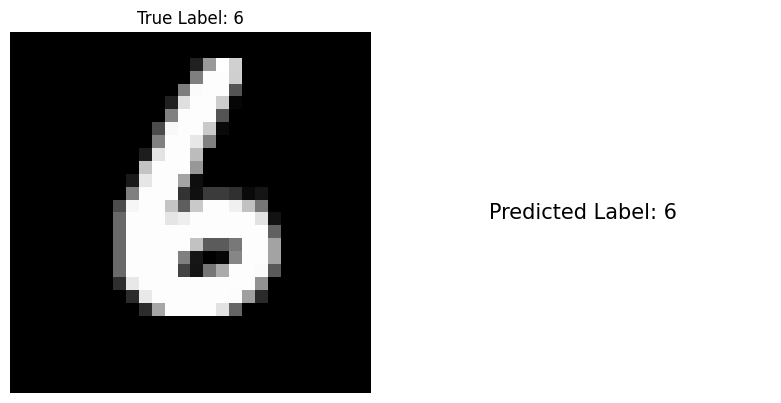

Task 2: Performance Comparison
Performance Comparison on Reduced Training Data and 100 Test Samples
Method: pure_python
Execution Time: 440.6683 seconds
Accuracy: 0.9100
Method: numpy
Execution Time: 7.6216 seconds
Accuracy: 0.9100
Method: numba
Execution Time: 0.5542 seconds
Accuracy: 0.9100

Task 3: Accuracy by Training Sample Size
Training Sample Size: 1000, Accuracy: 0.8300
Training Sample Size: 5000, Accuracy: 0.9000
Training Sample Size: 10000, Accuracy: 0.9200
Training Sample Size: 60000, Accuracy: 1.0000

Task 4: Full Dataset Test
Full Dataset Execution Time: 567.1751 seconds
Full Dataset Accuracy: 0.9691


In [ ]:
import numpy as np
import time
from numba import jit, prange
from keras.datasets import mnist
from matplotlib import pyplot as plt

# Load and preprocess MNIST data
def load_and_preprocess_data():
    (X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()
    X_train = X_train_full.reshape(X_train_full.shape[0], -1) / 255.0
    X_test = X_test_full.reshape(X_test_full.shape[0], -1) / 255.0
    return X_train, y_train_full, X_test, y_test_full

# Pure Python implementation for Euclidean distances
def compute_distances_pure_python(train_X, test_X):
    """
    Compute Euclidean distances using pure Python.
    """
    num_test = len(test_X)
    num_train = len(train_X)
    distances = [[0] * num_train for _ in range(num_test)]
    for i in range(num_test):
        for j in range(num_train):
            dist = 0
            for k in range(len(test_X[i])):
                dist += (test_X[i][k] - train_X[j][k]) ** 2
            distances[i][j] = dist ** 0.5
    return distances

# Numpy implementation for Euclidean distances
def compute_distances_numpy(train_X, test_X):
    """
    Compute Euclidean distances using Numpy.
    """
    distances = np.linalg.norm(test_X[:, np.newaxis] - train_X, axis=2)
    return distances

# Numba implementation for Euclidean distances
@jit(nopython=True, parallel=True)
def compute_distances_numba(train_X, test_X):
    """
    Compute Euclidean distances using Numba for acceleration.
    """
    num_test, num_train = test_X.shape[0], train_X.shape[0]
    distances = np.zeros((num_test, num_train))
    for i in prange(num_test):
        for j in range(num_train):
            distances[i, j] = np.sum((test_X[i] - train_X[j]) ** 2)
    return distances

# Nearest neighbor prediction function
def nearest_neighbor(train_X, train_y, test_X, method='numpy'):
    """
    Predict labels for test samples using the nearest neighbor algorithm.
    """
    if method == 'pure_python':
        distances = compute_distances_pure_python(train_X, test_X)
    elif method == 'numpy':
        distances = compute_distances_numpy(train_X, test_X)
    elif method == 'numba':
        distances = compute_distances_numba(train_X, test_X)
    nearest_indices = np.argmin(distances, axis=1)
    predictions = train_y[nearest_indices]
    return predictions

# Visualize test image and result
def plot_mnist_image_with_result(image, true_label, predicted_label):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'True Label: {true_label}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f'Predicted Label: {predicted_label}',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Performance comparison between Numpy and Numba
def measure_performance(train_X, train_y, test_X, test_y):
    methods = ['pure_python', 'numpy', 'numba']
    results = {}

    for method in methods:
        start_time = time.time()
        predictions = nearest_neighbor(train_X, train_y, test_X, method=method)
        elapsed_time = time.time() - start_time
        accuracy = np.mean(predictions == test_y[:len(predictions)])
        results[method] = {'time': elapsed_time, 'accuracy': accuracy}

    return results

# Measure accuracy by training sample size
def measure_accuracy_by_sample_size(train_X, train_y, test_X, test_y):
    sample_sizes = [1000, 5000, 10000, len(train_X)]
    accuracy_results = []

    for size in sample_sizes:
        X_train_subset = train_X[:size]
        y_train_subset = train_y[:size]

        predictions = nearest_neighbor(X_train_subset, y_train_subset, test_X[:100], method='numba')
        accuracy = np.mean(predictions == test_y[:100])
        accuracy_results.append((size, accuracy))

    return accuracy_results

# Test on full dataset
def test_full_dataset(train_X, train_y, test_X, test_y):
    start_time = time.time()
    predictions = nearest_neighbor(train_X, train_y, test_X, method='numba')
    elapsed_time = time.time() - start_time
    accuracy = np.mean(predictions == test_y)
    return elapsed_time, accuracy

# Main function
def main():
    # Load and preprocess data
    X_train, y_train, X_test, y_test = load_and_preprocess_data()

    # Task 1.1: Find the most similar image
    print("Task 1.1: Nearest Neighbor for One Test Image")
    test_image_index = np.random.randint(0, len(X_test))
    test_image = X_test[test_image_index:test_image_index + 1]
    true_label = y_test[test_image_index]

    predictions = nearest_neighbor(X_train[:5000], y_train[:5000], test_image, method='numba')
    predicted_label = predictions[0]

    print(f"True label of test image: {true_label}")
    print(f"Label of the most similar training image: {predicted_label}")
    print(f"Classes {'match' if true_label == predicted_label else 'do not match'}")

    plot_mnist_image_with_result(test_image, true_label, predicted_label)

    # Task 2: Measure performance with Numpy and Numba
    print("Task 2: Performance Comparison")
    reduced_X_train = X_train[:len(X_train) // 10]
    reduced_y_train = y_train[:len(y_train) // 10]
    test_X_subset = X_test[:100]
    test_y_subset = y_test[:100]

    print("Performance Comparison on Reduced Training Data and 100 Test Samples")
    performance_results = measure_performance(reduced_X_train, reduced_y_train, test_X_subset, test_y_subset)
    for method, result in performance_results.items():
        print(f"Method: {method}")
        print(f"Execution Time: {result['time']:.4f} seconds")
        print(f"Accuracy: {result['accuracy']:.4f}")


    # Task 3: Accuracy by training sample size
    print("\nTask 3: Accuracy by Training Sample Size")
    accuracy_results = measure_accuracy_by_sample_size(X_train, y_train, X_test, y_test)
    for size, accuracy in accuracy_results:
        print(f"Training Sample Size: {size}, Accuracy: {accuracy:.4f}")

    # Task 4: Full dataset test
    print("\nTask 4: Full Dataset Test")
    elapsed_time, accuracy = test_full_dataset(X_train, y_train, X_test, y_test)
    print(f"Full Dataset Execution Time: {elapsed_time:.4f} seconds")
    print(f"Full Dataset Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    main()
